# Mooomentums
Mooom is a strategy that heavily relies on momentum. It enriches dataframe with simple momentum and industrial momentum factors. Returns will be substracted by a cross-sectional median.

In [1]:
from functools import reduce
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None
np.seterr(divide="ignore", invalid="ignore")
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_parquet("../data/compustat_ibes_raw_alpha.1.parquet")

In [3]:
def conf(clf, X_test, y_test):
    f, ax = plt.subplots(figsize=(4.8, 4.8))
    y_test_pred = clf.predict(X_test)
    conf_mat = confusion_matrix(y_test, y_test_pred)
    conf_ax = sns.heatmap(
        conf_mat, ax=ax, annot=True, fmt="", cmap=plt.cm.Blues, cbar=False
    )
    conf_ax.set_xlabel("Predicted")
    conf_ax.set_ylabel("True")

In [4]:
def extreme(df):
    """Retain the 20% values that are the smallest and the 20% that are the largest."""
    top = df.y.quantile(0.8)
    low = df.y.quantile(0.2)
    return df[(df.y < low) | (df.y > top)]

In [18]:
def mooom(df):
    """
    Mooom is a strategy that heavily relies on momentum.
    It enriches dataframe with simple momentum and industrial momentum factors. 
    Returns will be substracted by a cross-sectional median.
    """
    df_mom = df[["classification",
                 "mcap",
                 "act",
                 "ceq",
                 "cogs",
                 "lct",
                 "nicon",
                 "revt",
                 "xrd",
                 "prccd",
                 "close"]]
    df_mom["profitability_roe"]=df_mom.nicon / df_mom.ceq
    df_mom["intangible_rdm"] = df_mom.xrd / df_mom.mcap
    df_mom["liquid_cur"] = df_mom.act / df_mom.lct
    df_mom["market_pe"] = df_mom.mcap / (df_mom.nicon * 10 ** 6)
    df_mom["market_mb"] = df_mom.mcap / (df_mom.ceq * 10 ** 6)
    df_mom["52wk_high"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x) - np.log(x.rolling(12, min_periods=1).max()))
    df_mom["mom_12m"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x.shift(2))-np.log(x.shift(13)))
    df_mom["mom_6m"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x).shift(2) - np.log(x.shift(7)))
    df_mom["mom_1m"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x) - np.log(x.shift(1)))
    df_mom["ind_mom_12m"] = df_mom.groupby(["date", "classification"]).mom_12m.transform("mean")
    df_mom["ind_mom_6m"] = df_mom.groupby(["date", "classification"]).mom_6m.transform("mean")
    df_mom["ind_mom_1m"] = df_mom.groupby(["date", "classification"]).mom_1m.transform("mean")
    df_mom["log_return"] = df_mom.close.groupby("gvkey").transform(lambda x: np.log(x.shift(-3)) - np.log(x))
    df_mom["y"] = df_mom.groupby("date").log_return.transform(lambda x: (x - x.median()).clip(-1,1))
    return df_mom.loc[df.prccd > 5, ["mcap",
                                     "profitability_roe",
                                     "intangible_rdm",
                                     "liquid_cur",
                                     "market_mb",
                                     "market_pe",
                                     "52wk_high",
                                     "mom_12m",
                                     "mom_6m",
                                     "mom_1m",
                                     "ind_mom_12m",
                                     "ind_mom_6m",
                                     "ind_mom_1m",
                                     "y"]].dropna()

In [19]:
df_mom = mooom(df)

## Regression

In [89]:
def r2(y_true, y_pred):
    r2 = 1 - np.sum((y_true - y_pred) ** 2)/np.sum(y_true ** 2)
    return r2

r2_score = make_scorer(r2)

In [171]:
df_train = df_mom.xs(slice("2002-01-01", "2012-01-01"), level="date", drop_level=False)
df_test = df_mom.xs(slice("2012-01-01", "2016-01-01"), level="date", drop_level=False)
X_train = df_train.drop(["y"], axis=1).to_numpy()
y_train = df_train["y"].to_numpy()
X_test = df_test.drop(["y"], axis=1).to_numpy()
y_test = df_test["y"].to_numpy()

In [172]:
xgb_reg = XGBRegressor(n_estimators=100, max_depth=3, n_jobs=-1)
xgb_fit = xgb_reg.fit(X_train, y_train)
train_score = r2_score(xgb_reg, X_train, y_train)
test_score = r2_score(xgb_reg, X_test, y_test)
print(f"R2 on training set: {train_score}\nR2 on test set: {test_score}")

R2 on training set: 0.08926540338353117
R2 on test set: 0.027067763216712337


## Binary Classification

In [624]:
df_train = df_mom.xs(slice("2002-01-01", "2012-01-01"), level="date", drop_level=False)
df_test = df_mom.xs(slice("2012-01-01", "2016-01-01"), level="date", drop_level=False)
X_train = df_train.drop(["y"], axis=1).to_numpy()
y_train = np.where(df_train.y > 0, 0, 1)
X_test = df_test.drop(["y"], axis=1).to_numpy()
y_test = np.where(df_test.y > 0, 0, 1)

Accuracy on training set: 0.5890400202413255
Accuracy on test set: 0.5606404113591212
              precision    recall  f1-score   support

        sell       0.57      0.70      0.63     22788
         buy       0.54      0.40      0.46     19997

    accuracy                           0.56     42785
   macro avg       0.56      0.55      0.55     42785
weighted avg       0.56      0.56      0.55     42785



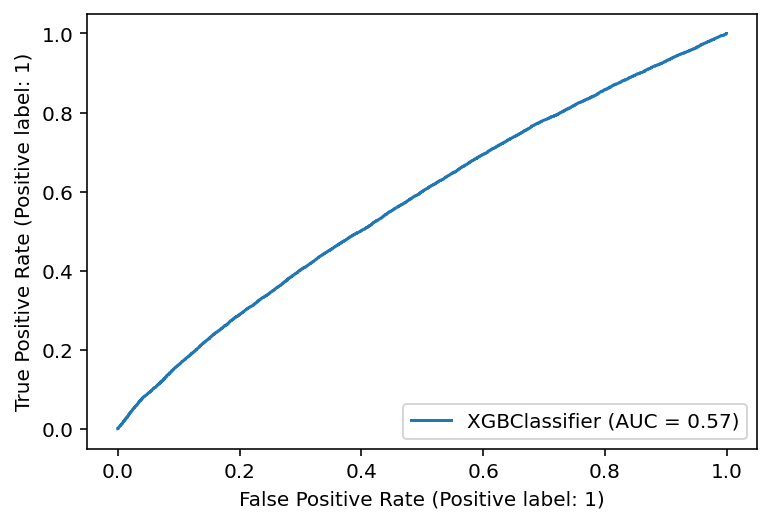

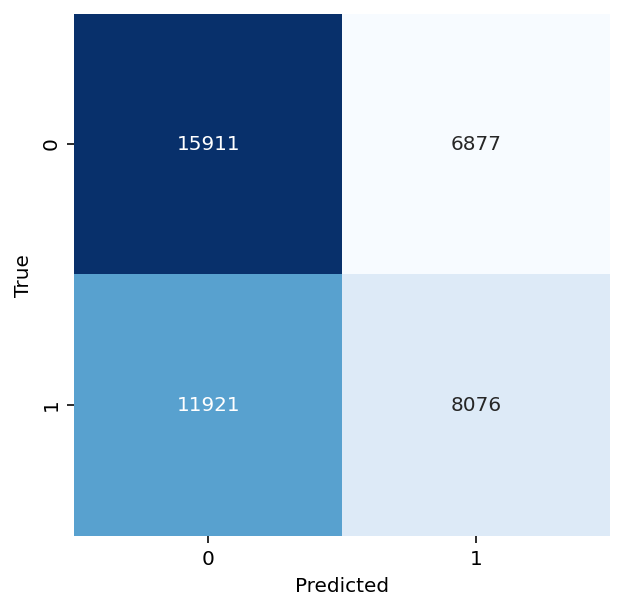

In [625]:
xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, eval_metric='logloss', n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, y_train)
y_pred = xgb_clf.predict(X_test)
train_score = accuracy_score(y_train, xgb_clf.predict(X_train))
test_score = accuracy_score(y_test, y_pred)
plot_roc_curve(xgb_clf, X_test, y_test)
conf(xgb_clf, X_test, y_test)
print(f"Accuracy on training set: {train_score}\nAccuracy on test set: {test_score}")
print(classification_report(y_test, y_pred, target_names=["sell", "buy"]))

## Multi Classification

In [10]:
def threshold(y):
    thres = 0.1
    y_0 = np.where(y < -thres, -1, y)
    y_1 = np.where((y <= thres) & (y >= -thres), 0, y_0)
    y_2 = np.where(y > thres, 1, y_1)
    return y_2

In [631]:
df_train = df_mom.xs(slice("2002-01-01", "2012-01-01"), level="date", drop_level=False).groupby("date").apply(extreme)
df_test = df_mom.xs(slice("2012-01-01", "2016-01-01"), level="date", drop_level=False)
X_train = df_train.drop(["y"], axis=1).to_numpy()
y_train= threshold(df_train.y)
X_test = df_test.drop(["y"], axis=1).to_numpy()
y_test= threshold(df_test.y)

Accuracy on training set: 0.5988577362409138
Accuracy on test set: 0.22731338149294805
              precision    recall  f1-score   support

        sell       0.24      0.48      0.32      7361
        hold       1.00      0.00      0.00     27269
         buy       0.22      0.71      0.34      8975

    accuracy                           0.23     43605
   macro avg       0.49      0.40      0.22     43605
weighted avg       0.71      0.23      0.12     43605



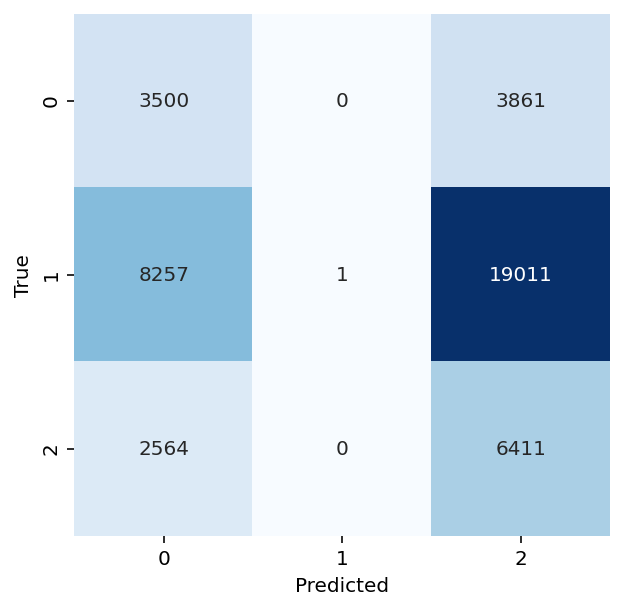

In [632]:
xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, eval_metric='logloss', n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, y_train)
y_pred= xgb_clf.predict(X_test)
train_score = accuracy_score(y_train, xgb_clf.predict(X_train))
test_score = accuracy_score(y_test, y_pred)
conf(xgb_clf, X_test, y_test)
print(f"Accuracy on training set: {train_score}\nAccuracy on test set: {test_score}")
print(classification_report(y_test, y_pred, target_names=["sell", "hold", "buy"]))

In [633]:
df_test.head()

mcap  profitability_roe  intangible_rdm  \
gvkey  date                                                          
001166 2012-01-31  1.388195e+09           0.283072    9.321457e-08   
       2012-02-29  1.551943e+09           0.283072    8.337935e-08   
       2012-03-31  1.584237e+09           0.283072    8.167971e-08   
       2012-04-30  1.477152e+09           0.283072    8.760101e-08   
       2012-05-31  1.543062e+09           0.283072    8.385926e-08   

                   liquid_cur  market_mb  market_pe  52wk_high    mom_6m  \
gvkey  date                                                                
001166 2012-01-31    2.619295   2.103976   7.432645  -0.151689 -0.303428   
       2012-02-29    2.619295   2.352156   8.309381  -0.041248  0.133782   
       2012-03-31    2.619295   2.401101   8.482287  -0.016330  0.313668   
       2012-04-30    2.619295   2.238801   7.908936  -0.088975  0.403335   
       2012-05-31    2.619295   2.338695   8.261827  -0.047924  0.346085   

                     mom_1m  ind_mom_12m  ind_mom_6m  ind_mom_1m         y  
gvkey  date                                                                 
001166 2012-01-31  0.104811    -0.174273   -0.221785    0.040076  0.055035  
       2012-02-29  0.107376    -0.195260   -0.165090    0.085179  0.057250  
       2012-03-31  0.024918    -0.199705   -0.056779    0.006121  0.130124  
       2012-04-30 -0.077259    -0.106108    0.056517   -0.015265  0.194061  
       2012-05-31  0.029335    -0.172721    0.044654   -0.053616  0.001138

<AxesSubplot:>

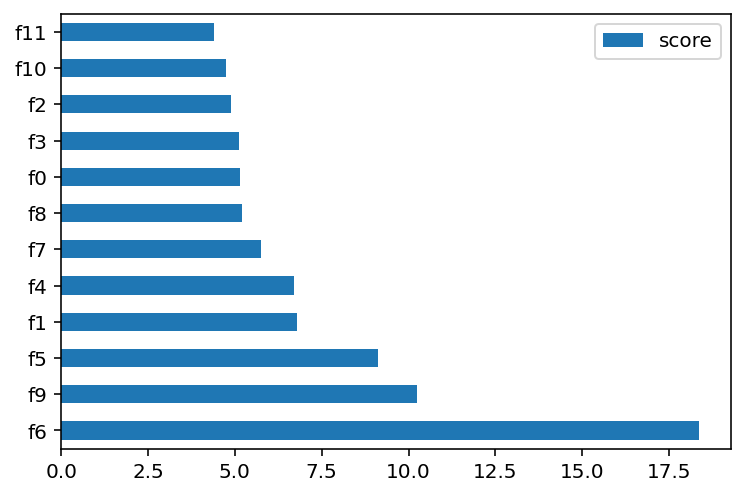

In [634]:
feature_important = xgb_clf.get_booster().get_score(importance_type="gain")
keys = list(feature_important.keys())
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by="score", ascending=False)
data.plot(kind='barh')

## Portfolio Return

In [20]:
df_train = df_mom.xs(slice("2002-01-01", "2012-01-01"), level="date", drop_level=False).groupby("date").apply(extreme)
df_test = df_mom.xs(slice("2012-01-01", "2016-01-01"), level="date", drop_level=False)
X_train = df_train.drop(["y"], axis=1).to_numpy()
y_train= threshold(df_train.y)
X_test = df_test.drop(["y"], axis=1).to_numpy()
y_test = threshold(df_test.y)
xgb_clf = XGBClassifier(n_estimators=100, max_depth=3, eval_metric='logloss', n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, y_train)
y_pred= xgb_clf.predict(X_test)
train_score = accuracy_score(y_train, xgb_clf.predict(X_train))
test_score = accuracy_score(y_test, y_pred)
print(f"Accuracy on training set: {train_score}\nAccuracy on test set: {test_score}")
print(classification_report(y_test, y_pred, target_names=["sell", "hold", "buy"]))

Accuracy on training set: 0.599542234332425
Accuracy on test set: 0.2277667406801449
              precision    recall  f1-score   support

        sell       0.24      0.47      0.32      7102
        hold       0.00      0.00      0.00     26866
         buy       0.22      0.72      0.34      8817

    accuracy                           0.23     42785
   macro avg       0.15      0.40      0.22     42785
weighted avg       0.09      0.23      0.12     42785



In [21]:
def frame_to_signals(frame, estimator):
    X = frame.drop(columns="y").to_numpy()
    short_array = -1 * estimator.predict_proba(X)[:, 0]
    long_array = estimator.predict_proba(X)[:, -1]
    short_signal = pd.Series(short_array, frame.index)
    long_signal = pd.Series(long_array, frame.index)
    return short_signal, long_signal

In [22]:
def noise_to_belief(signal, n):
    return signal.groupby("date", group_keys=False).apply(lambda x: x.sort_values(ascending=False).head(n))

In [23]:
def monthly_to_daily(signal, months, weight):
    daily_signals = []
    for index, value in signal.iteritems():
        gvkey = index[0]
        predict_date = pd.to_datetime(index[1])
        start = predict_date + DateOffset(days=1)
        end = predict_date + DateOffset(months=months)
        date_range = pd.date_range(start, end, freq="D", name="date")
        daily_idx = pd.MultiIndex.from_tuples([(gvkey, date) for date in date_range], names=["gvkey", "date"])
        if weight == "equal":
            daily_signal = pd.Series(np.sign(value), daily_idx)
        elif weight == "value":
            daily_signal = pd.Series(value, daily_idx)
        daily_signals.append(daily_signal)
    return pd.concat(daily_signals)

In [24]:
def signals_to_positions(short_signal, long_signal, n=10, months=3, weight="equal"):
    short_belief = noise_to_belief(short_signal, n)
    long_belief = noise_to_belief(long_signal, n)
    short_daily = monthly_to_daily(short_belief, months, weight)
    long_daily = monthly_to_daily(long_belief, months, weight)
    short_position = short_daily.groupby(["gvkey", "date"]).agg("sum")
    long_position = long_daily.groupby(["gvkey", "date"]).agg("sum")
    neutral_position = pd.concat([short_position, long_position]).groupby(["gvkey", "date"]).agg("sum")
    return short_position, long_position, neutral_position

In [39]:
def position_to_margin(data, position, tx=-0.002, method="log", rebalance=True):
    merged = pd.merge(position.rename("position"), data.close, how="left", left_index=True, right_index=True)
    merged["close"] = merged.close.groupby("gvkey").fillna(method="ffill")
    merged["tx"] = np.where(position.shift(1) != position, -0.002, 0)
    if method == "log":
        merged["margin"] = merged.close.groupby("gvkey").transform(lambda x: np.log(x / x.shift(1))).fillna(0)
        margin = merged.position * merged.margin + merged.tx
        margin = margin + merged.tx * abs(margin) * 2
        margin = margin.droplevel("gvkey").resample("D").mean().cumsum()
    elif method == "percent":
        merged["margin"] = merged.close.groupby("gvkey").transform(lambda x: x.pct_change(1)).fillna(0)
        margin = merged.position * merged.margin + merged.tx
        margin = margin + merged.tx * abs(margin) * 2
        margin = (margin.droplevel("gvkey").resample("D").mean() + 1).cumprod()
    if not rebalance:
        margin = merged.position * merged.margin
        margin = margin.groupby("gvkey").cumsum().droplevel("gvkey").resample("D").mean()
    return margin

<AxesSubplot:xlabel='date'>

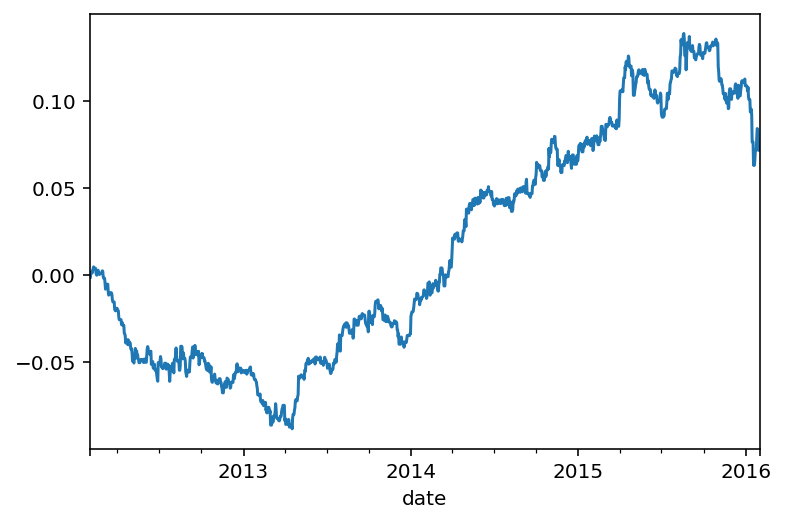

In [46]:
data = pd.read_parquet("../data/daily_price_backtest.parquet")
data = data[data.index.get_level_values("gvkey") != '249103']
short_signal, long_signal = frame_to_signals(df_test, xgb_clf)
short_position, long_position, neutral_position = signals_to_positions(short_signal, long_signal, n=30, months=3, weight="equal")
margin = position_to_margin(data, neutral_position, method="log")
margin.plot()